## Data Cleaning

In [4]:
import os
import json
import warnings
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

warnings.filterwarnings("ignore")


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [6]:
# read data from numeric and nlp, then concat
num_df = pd.read_csv("data.csv")
nlp_df = pd.read_csv("nlp.csv")
num_df['date'] = pd.to_datetime(num_df['date'])
nlp_df['date'] = pd.to_datetime(nlp_df['date'])
data_df = pd.merge(num_df, nlp_df, on='date', how='inner')  # inner表示只保留在num_df和nlp_df中都有的日期
data_df = data_df[[col for col in data_df.columns if col not in ['WTI_price', 'Dubai_price', 'Brent_price']] + ['WTI_price', 'Dubai_price', 'Brent_price']]

# 資料清洗、補值
data_df['date'] = data_df['date'].dt.strftime('%Y%m%d').astype(float)
data_df = data_df.fillna(data_df.mean())

data_df.head()

,date,WTI_export,Dubai_export,Brent_export,Unknown_export,exchange rate,WTI_change,Dubai_change,Brent_change,US Dollar Indicator,...,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,WTI_price,Dubai_price,Brent_price
0,20200101.0,35048.31,5371.32,1392.70,860.18,30.11,6.01979,0.032699,0.041316,96.39,...,0.000606,0.000606,0.000606,0.000606,0.000606,0.994545,0.000606,61.14,65.41,67.43
1,20200102.0,35048.31,5371.32,1392.70,860.18,30.11,0.00000,0.000000,0.000000,96.85,...,0.001176,0.001177,0.409723,0.001177,0.001177,0.001177,0.580864,61.14,65.41,67.43
2,20200103.0,35048.31,5371.32,1392.70,860.18,30.10,2.99000,3.880000,3.400000,96.84,...,0.000662,0.000662,0.000662,0.000662,0.000662,0.000662,0.994039,62.97,67.95,69.72
3,20200104.0,42057.98,6445.58,1671.24,1032.22,30.11,0.14000,0.100000,0.040000,96.78,...,0.000559,0.000559,0.128271,0.000559,0.000559,0.473013,0.394805,63.06,68.02,69.75
4,20200105.0,42057.98,6445.58,1671.24,1032.22,30.11,0.14000,0.100000,0.060000,96.73,...,0.000719,0.000719,0.000720,0.000719,0.000719,0.071880,0.922364,63.15,68.09,69.79


## Feature Engineering

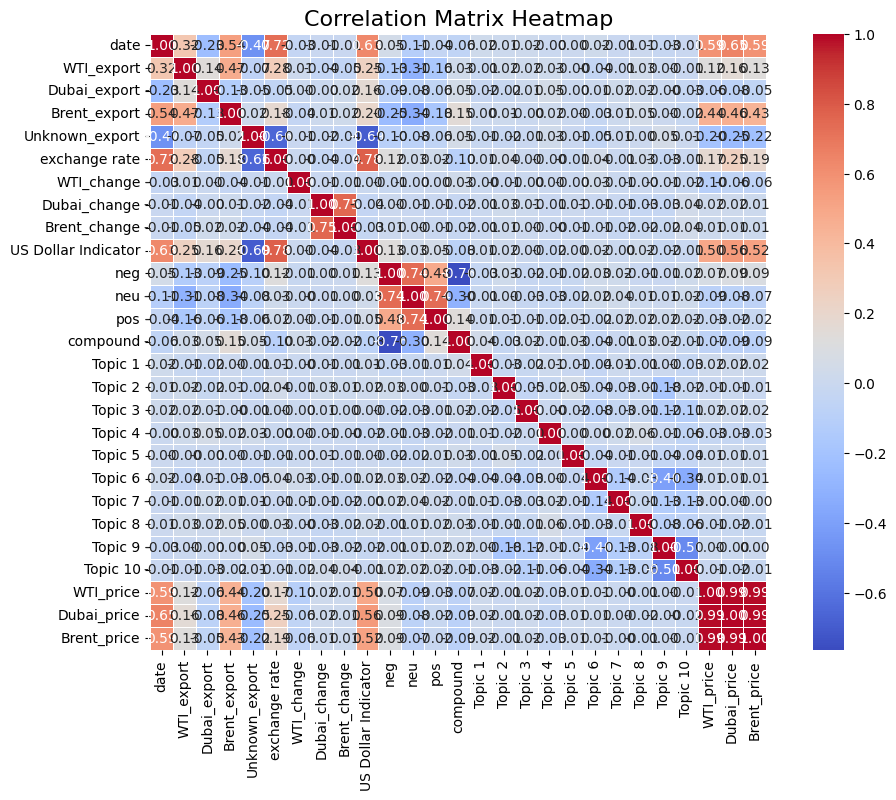

date                   float64
WTI_export             float64
Dubai_export           float64
Brent_export           float64
Unknown_export         float64
exchange rate          float64
WTI_change             float64
Dubai_change           float64
Brent_change           float64
US Dollar Indicator    float64
neg                    float64
neu                    float64
pos                    float64
compound               float64
Topic 1                float64
Topic 2                float64
Topic 3                float64
Topic 4                float64
Topic 5                float64
Topic 6                float64
Topic 7                float64
Topic 8                float64
Topic 9                float64
Topic 10               float64
WTI_price              float64
Dubai_price            float64
Brent_price            float64
dtype: object

In [7]:
########## 特徵工程 #########
correlation_matrix = data_df.corr()
plt.figure(figsize=(12, 8))  # 設置畫布大小
sns.heatmap(correlation_matrix, 
            annot=True,  # 在每個格子中顯示數值
            fmt=".2f",   # 數值格式保留兩位小數
            cmap="coolwarm",  # 配色方案
            square=True,  # 格子正方形
            linewidths=0.5)  # 格子邊框寬度
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()


data_df.dtypes

In [8]:
# train, valid, test split
train_df = data_df[data_df['date'] < 20240401]
valid_df = data_df[(data_df['date'] >= 20240401) & (data_df['date'] <= 20240630)]
test_df = data_df[data_df['date'] > 20240630]


# features = train_df.columns[:-3]
# target = train_df.columns[-3:]
# X_train = train_df[features]
# y_train = train_df[target]
# X_valid = valid_df[features]
# y_valid = valid_df[target]
# X_test = test_df[features]
# y_test = test_df[target]


train_df.shape, valid_df.shape, test_df.shape
valid_df.head()
# test_df.head()


,date,WTI_export,Dubai_export,Brent_export,Unknown_export,exchange rate,WTI_change,Dubai_change,Brent_change,US Dollar Indicator,...,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,WTI_price,Dubai_price,Brent_price
1552,20240401.0,26202.63,3334.24,1994.97,254.11,31.98,0.17,0.33,0.09,105.02,...,0.001408,0.001408,0.987322,0.001409,0.001408,0.001409,0.001409,84.54,89.45,86.50
1553,20240402.0,26202.63,3334.24,1994.97,254.11,32.08,1.67,0.20,1.31,104.82,...,0.000488,0.000488,0.000488,0.000488,0.000488,0.640290,0.355807,85.95,89.63,87.63
1554,20240403.0,26202.63,3334.24,1994.97,254.11,32.06,0.31,1.86,3.39,104.25,...,0.001515,0.001515,0.001515,0.001515,0.001516,0.383983,0.603894,86.22,91.30,90.60
1555,20240404.0,26202.63,3334.24,1994.97,254.11,32.06,1.33,2.02,-0.31,104.12,...,0.000633,0.000633,0.152498,0.000633,0.000633,0.361564,0.481507,87.37,93.14,90.32
1556,20240405.0,26202.63,3334.24,1994.97,254.11,32.07,0.37,-0.23,2.76,104.30,...,0.001075,0.001075,0.887840,0.001075,0.001075,0.087829,0.001076,87.69,92.93,92.81


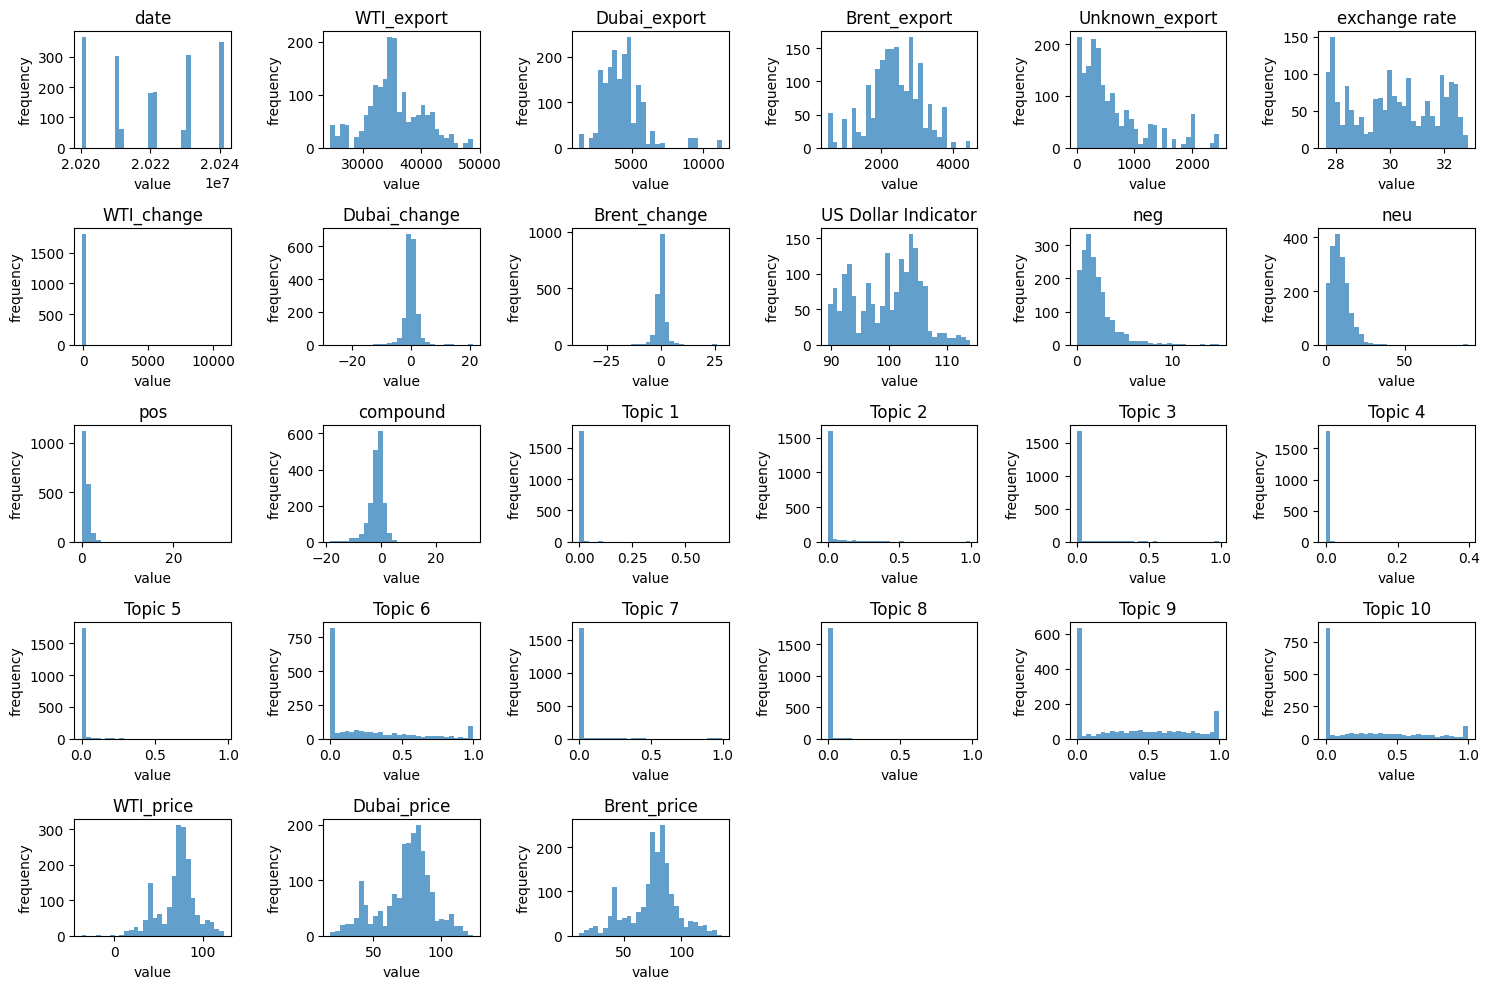

In [9]:
# 畫出所有特徵的 histogram，看數據的分布
plt.figure(figsize=(15, 10))
for i, column in enumerate(train_df.columns):
    plt.subplot(5, 6, i + 1)
    plt.hist(data_df[column], bins=30, alpha=0.7)
    plt.title(column)
    plt.xlabel('value')
    plt.ylabel('frequency')
plt.tight_layout()
plt.show()


In [17]:
def split_features(df, target_feature, train=True, scaler=None, selected_features=None, ):
    df['lag_7'] = df[target_feature].shift(7)
    # df['ma20'] = df[target_feature].rolling(window=20).mean()
    # df['ma60'] = df[target_feature].rolling(window=60).mean()
    # df['ma120'] = df[target_feature].rolling(window=120).mean()
    # df['ma180'] = df[target_feature].rolling(window=180).mean()
    # df = df.iloc[7:]  # 刪除前 7 行，確保 lag_7 無 NaN
    # df = df.fillna(df.mean())  # 填充其他 NaN 值
    # 預定義數值型和 NLP 特徵列表
    numeric_features_all = ['WTI_export', 'Dubai_export', 'Brent_export', 'Unknown_export', 
                            'exchange rate', 'WTI_change', 'Dubai_change', 'Brent_change', 
                            'US Dollar Indicator', 'lag_7',
                            'WTI_price', 'Dubai_price', 'Brent_price']
    # numeric_features_all = ['WTI_export', 'Dubai_export', 'Brent_export', 'Unknown_export', 
    #                         'exchange rate', 'WTI_change', 'Dubai_change', 'Brent_change', 
    #                         'US Dollar Indicator', 'lag_7', 'ma20','ma60','ma120','ma180',
    #                         'WTI_price', 'Dubai_price', 'Brent_price']
    nlp_features_all = ['neg', 'neu', 'pos', 'compound', 
                        'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 
                        'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']
    
    if train:
        # 計算特徵重要性 (僅基於訓練集)
        xgb_model = XGBRegressor(n_estimators=143, learning_rate=0.026209147132450806, max_depth=4, random_state=42)
        lgb_model = LGBMRegressor(n_estimators=186, learning_rate=0.01162835695998187, max_depth=3, random_state=42)
        cat_model = CatBoostRegressor(n_estimators=252, learning_rate=0.0868940443602814, depth=3, verbose=0, random_state=42)
        xgb_model.fit(df, df[target_feature])  
        lgb_model.fit(df, df[target_feature])  
        cat_model.fit(df, df[target_feature])  
        xgb_importances = xgb_model.feature_importances_
        lgb_importances = lgb_model.feature_importances_
        cat_importances = cat_model.feature_importances_
        feature_importances = np.mean([xgb_importances, lgb_importances, cat_importances], axis=0)
        feature_names = df.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

        # 保存選擇的特徵
        selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()

    # 確保valid和test使用相同的特徵
    # df = df[selected_features]
    X_numeric = df[numeric_features_all].loc[:, df[numeric_features_all].columns.isin(selected_features)]
    numeric_features = X_numeric.columns
    X_nlp = df[nlp_features_all].loc[:, df[nlp_features_all].columns.isin(selected_features)]
    scaler = MinMaxScaler()
    # if train:
    #     X_numeric = scaler.fit_transform(X_numeric)
    # else:
    X_numeric = scaler.fit_transform(X_numeric)
    X = pd.concat([pd.DataFrame(X_numeric, columns=numeric_features), X_nlp.reset_index(drop=True)], axis=1)
    # print(X.head())
    print(np.isnan(X).sum())
    X.fillna(X.mean(), inplace=True)
    return scaler, X, selected_features

def prepare_data_with_features(df, target_feature, seq_length, train=True, scaler=None, selected_features=None):
    scaler, X_processed, selected_features = split_features(
        df, target_feature=target_feature, train=train, scaler=scaler, selected_features=selected_features
    )
    # exclude_columns = [target_feature, 'date']
    exclude_columns = [ 'date']
    features = [col for col in X_processed.columns if col not in exclude_columns]
    scaled_data = X_processed[features].values

    # 確保序列和目標值對齊
    sequences = [scaled_data[i:i + seq_length] for i in range(len(scaled_data) - seq_length)]
    y = X_processed[target_feature].values[seq_length:]
    X_tensor = torch.tensor(sequences, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    print(X_processed.shape, y.shape)
    return scaler, X_tensor, y_tensor, selected_features


In [58]:
# 整合後的數據準備過程
def prepare_data(train_df, valid_df, test_df,target_feature, seq_length):
   

    # 處理訓練數據
    scaler, X_train, y_train, selected_features = prepare_data_with_features(
        train_df, target_feature, seq_length, train=True
    )
    num_features = X_train.shape[2]
    # 處理驗證數據
    _, X_valid, y_valid, _ = prepare_data_with_features(
        valid_df, target_feature, seq_length, train=False, scaler=scaler, selected_features=selected_features
    )

    # 處理測試數據
    _, X_test, y_test, _ = prepare_data_with_features(
        test_df, target_feature, seq_length, train=False, scaler=scaler, selected_features=selected_features
    )
    print(X_test.shape, y_test.shape)
    # 建立 DataLoader
    batch_size = 8
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # 確認數據大小(1552-30=1522)
    # print(f'Training DataLoader size: {len(WTI_train_loader.dataset)}')
    # print(f'Validation DataLoader size: {len(WTI_valid_loader.dataset)}')
    # print(f'Test DataLoader size: {len(WTI_test_loader.dataset)}')
    return train_loader, valid_loader, test_loader, num_features
seq_length = 7
WTI_train_loader, WTI_valid_loader, WTI_test_loader,WTI_feature_num = prepare_data(train_df, valid_df, test_df, 'WTI_price', seq_length=seq_length)
Dubai_train_loader, Dubai_valid_loader, Dubai_test_loader, Dubai_feature_num = prepare_data(train_df, valid_df, test_df, 'Dubai_price', seq_length=seq_length)
Brent_train_loader, Brent_valid_loader, Brent_test_loader, Brent_feature_num = prepare_data(train_df, valid_df, test_df, 'Brent_price', seq_length=seq_length)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6517
[LightGBM] [Info] Number of data points in the train set: 1552, number of used features: 28
[LightGBM] [Info] Start training from score 70.283048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

## Training Model

In [12]:
# import torch
# import torch.nn as nn

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=4, dropout=0.2, bidirectional=True)
#         self.attention = nn.Linear(hidden_size * 2, 1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
#         self.bn1 = nn.BatchNorm1d(hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size//2)
#         self.bn2 = nn.BatchNorm1d(hidden_size//2)
#         self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
#         self.bn3 = nn.BatchNorm1d(hidden_size//4)
#         self.fc4 = nn.Linear(hidden_size//4, output_size)
    
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         attention_scores = self.attention(lstm_out)
#         attention_weights = torch.softmax(attention_scores, dim=1)
#         lstm_out_weighted = (lstm_out * attention_weights).sum(dim=1)

#         ##  FC layers
#         output = self.fc1(lstm_out_weighted)
#         output = self.bn1(output)
#         output = self.relu(output)
#         output = self.dropout(output)

#         output = self.fc2(output)
#         output = self.bn2(output)
#         output = self.relu(output)
#         # output = self.dropout(output)
#         output = self.fc3(output)
#         output = self.bn3(output)
#         output = self.relu(output)  
#         # output = self.dropout(output)
#         output = self.fc4(output)

#         return output





In [49]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size,hidden_size = 0, output_size = 1):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 50, batch_first=True, )
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(50, 60, batch_first=True,   )
        self.dropout2 = nn.Dropout(0.2)
        
        self.lstm3 = nn.LSTM(60, 80, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        
        self.lstm4 = nn.LSTM(80, 120, batch_first=True)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc = nn.Linear(120, output_size)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        
        x, _ = self.lstm4(x)
        x = self.dropout4(x)
        
        # Only take the last output of the sequence
        x = x[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        x = self.fc(x)  # Final dense layer
        
        return x


In [59]:
import matplotlib.pyplot as plt
import numpy as np
# Initialize the model
def train_model(train_loader=None, test_loader=None, feature_num=None):
    output_size = 1  # For predicting WTI_price, Dubai_price, and Brent_price

    # Input size is the number of features (columns) in X_train, excluding the target columns
    input_size =feature_num  # Number of features in the input data
    hidden_size = 512  # Hidden layer size (adjustable)

    # Initialize the model with input_size, hidden_size, and output_size
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    model = model.to(device)
    # Print the model architecture

    print(model)

    # Define optimizer and loss function
    criterion = nn.MSELoss()  # Huber loss combines MSE and MAE
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 500
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # Predictions
            loss = criterion(outputs, y_batch)  # Compute loss for multi-target
            # print(outputs, y_batch)
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Accumulate batch loss

        train_loss /= len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                #check 有無nan
                if(torch.isnan(X_batch).any() or torch.isnan(y_batch).any()):
                    print(X_batch, y_batch)
                # print(X_batch, y_batch)
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)  # Predictions
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()  # Accumulate batch loss

        test_loss /= len(test_loader)  # Average validation loss
        test_losses.append(test_loss)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        
    return model, train_losses, test_losses
    
WTI_model, WTI_train_losses, WTI_test_losses = train_model(WTI_train_loader, WTI_test_loader,WTI_feature_num)
Dubai_model, Dubai_train_losses, Dubai_test_losses = train_model(Dubai_train_loader, Dubai_test_loader,Dubai_feature_num)
Brent_model, Brent_train_losses, Brent_test_losses = train_model(Brent_train_loader, Brent_test_loader,Brent_feature_num)


LSTMModel(
  (lstm1): LSTM(11, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 60, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(60, 80, batch_first=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (lstm4): LSTM(80, 120, batch_first=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=120, out_features=1, bias=True)
)
Epoch 1/500, Train Loss: 0.0419, Test Loss: 0.1648
Epoch 2/500, Train Loss: 0.0087, Test Loss: 0.1661
Epoch 3/500, Train Loss: 0.0084, Test Loss: 0.1703
Epoch 4/500, Train Loss: 0.0091, Test Loss: 0.1798
Epoch 5/500, Train Loss: 0.0089, Test Loss: 0.1839
Epoch 6/500, Train Loss: 0.0088, Test Loss: 0.1948
Epoch 7/500, Train Loss: 0.0090, Test Loss: 0.1959
Epoch 8/500, Train Loss: 0.0084, Test Loss: 0.2079
Epoch 9/500, Train Loss: 0.0079, Test Loss: 0.2190
Epoch 10/500, Train Loss: 0.0082, Test Loss: 0.2169
Epoch 11/500, Train Loss: 0.0079, Test Loss: 0.2196
Epoch 12/500, Train 

# Validation

In [68]:
def validate_model(model, valid_loader):    
    model.eval()
    predictions = []
    actuals = []
    # Storage for predictions and actuals for each oil type
    
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # Predictions
            predictions.append(outputs.cpu().numpy())  # Store predictions
            actuals.append(y_batch.cpu().numpy())  # Store actual values
            # print(outputs, y_batch)

    # Flatten the lists for evaluation
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Calculate RMSE for each oil type
    from sklearn.metrics import mean_squared_error
    import math
    # mse
    mse = mean_squared_error(actuals, predictions)
    #rmse
    rmse = math.sqrt(mse)
    #r^2
    r2 = r2_score(actuals, predictions)
    #MAE
    mae = mean_absolute_error(actuals, predictions)
    #print
    print(f"Validation Mean Squared Error: {mse:.4f}")
    print(f"Validation Root Mean Squared Error: {rmse:.4f}")
    print(f"Validation Mean Absolute Error: {mae:.4f}")
    print(f"Validation R^2: {r2:.4f}")

    return  actuals, predictions